In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [5]:
# Загрузка данных
file_path = "MainDF.csv"  # Укажите путь к вашему CSV-файлу
df = pd.read_csv(file_path, na_values=[''])
df = df.sort_values(by=["Компания", "year"])
df.to_csv("MainDF.csv", index=False)

/tmp/ipykernel_202433/786846725.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=[''])


In [6]:
start_col = df.columns.get_loc("size_cat") + 1
end_col = df.columns.get_loc("year")  # Определяем конец финансовых показателей

# Выбираем только финансовые показатели
financial_data = df.iloc[:, start_col:end_col]

In [7]:
# Удаление строк, где отсутствуют все финансовые данные
cleaned_df = df.dropna(thresh=len(financial_data.columns) - 6, subset=financial_data.columns)

# Сортировка данных по году для каждой компании
cleaned_df = cleaned_df.sort_values(by=["Компания", "year"])

# # Сохранение очищенного датасета
# cleaned_df.to_csv("cleaned_dataset.csv", index=False)

print(f"Удалено {len(df) - len(cleaned_df)} строк, где отсутствовали финансовые данные.")


Удалено 11137 строк, где отсутствовали финансовые данные.


In [8]:
# Определяем компании с разными значениями в столбце "industry"
companies_with_different_industries = cleaned_df.groupby("Компания")["industry"].nunique()
companies_with_different_industries = companies_with_different_industries[companies_with_different_industries > 1].index

# Фильтрация исходного датасета
cleaned_df = cleaned_df[~cleaned_df['Компания'].isin(companies_with_different_industries)]

# Определяем компании с одинаковым значением в столбце "name", но разными значениями в столбце "Компания"
names_with_different_companies = cleaned_df.groupby("name")["Компания"].nunique()
names_with_different_companies = names_with_different_companies[names_with_different_companies > 1].index

# Фильтрация исходного датасета
cleaned_df = cleaned_df[~cleaned_df['name'].isin(names_with_different_companies)]

# Удаление компаний, у которых меньше либо равно 4 наблюдений
cleaned_df = cleaned_df.groupby('Компания').filter(lambda x: len(x) > 4)

# # Сохранение очищенного датасета
# cleaned_df.to_csv("cleaned_dataset.csv", index=False)

print(f"Удалено {len(companies_with_different_industries)} компаний, которые имеют разные значения в столбце 'industry'.")
print(f"Удалено {len(names_with_different_companies)} компаний, которые имеют одинаковое значение в столбце 'name', но разные значения в столбце 'Компания'.")
print(f"Удалено компаний с менее чем 5 наблюдениями: {len(df) - len(cleaned_df)}")

Удалено 50 компаний, которые имеют разные значения в столбце 'industry'.
Удалено 10 компаний, которые имеют одинаковое значение в столбце 'name', но разные значения в столбце 'Компания'.
Удалено компаний с менее чем 5 наблюдениями: 12835


In [9]:
# Удаление компаний, у которых ни в одном году нет внедрения технологий
companies_with_technology = cleaned_df.dropna(subset=['Технология'])['Компания'].unique()
cleaned_df = cleaned_df[cleaned_df['Компания'].isin(companies_with_technology)]

# # Сохранение очищенного датасета
# cleaned_df.to_csv("cleaned_dataset.csv", index=False)

print(f"Удалено компаний без внедрения технологий: {len(df['Компания'].unique()) - len(cleaned_df['Компания'].unique())}")

# def filter_companies(group):
#     min_year = group['year'].min()
#     max_year = group['year'].max()
    
#     # Фильтруем строки, где есть внедрение технологии (не пустое значение в колонке "Технология")
#     tech_entries = group[group['Технология'].notna()]
    
#     # Проверяем, есть ли внедрения вне первых двух и последних двух лет
#     has_valid_entries = any((tech_entries['year'] > min_year + 1) & (tech_entries['year'] < max_year - 1))
    
#     if has_valid_entries:
#         # Если есть хотя бы одно внедрение вне первых двух и последних двух лет, оставляем компанию
#         return group
#     else:
#         # Если все внедрения приходятся на первые два или последние два года, удаляем компанию
#         return pd.DataFrame()

# # Применяем фильтрацию к каждой группе (компании)
# df = cleaned_df
# cleaned_df = cleaned_df.groupby('Компания').apply(filter_companies).reset_index(drop=True)

# # Сохранение очищенного датасета
# cleaned_df.to_csv("cleaned_dataset.csv", index=False)

# Подсчет удаленных компаний
original_companies = df['Компания'].unique()
cleaned_companies = cleaned_df['Компания'].unique()
removed_companies = set(original_companies) - set(cleaned_companies)

print(f"Удалено компаний, у которых все внедрения технологий приходятся на первые два года или последние два года: {len(removed_companies)}")


Удалено компаний без внедрения технологий: 1214
Удалено компаний, у которых все внедрения технологий приходятся на первые два года или последние два года: 1214


In [10]:
# Группировка данных по компаниям
grouped = cleaned_df.groupby('Компания')

# Функция для проверки пропущенных годов
def has_missing_years(group):
    years = group['year'].sort_values()
    return any(years.diff().dropna() > 1)

# Применение функции к каждой группе и подсчет количества компаний с пропущенными годами
companies_with_missing_years = grouped.filter(has_missing_years)['Компания'].nunique()

print(f"Количество компаний с пропущенными годами: {companies_with_missing_years}")

Количество компаний с пропущенными годами: 182


In [11]:
unique_company_count = cleaned_df['Компания'].nunique()
print(f"Unique count of 'Компания': {unique_company_count}")

Unique count of 'Компания': 795


In [12]:
df = cleaned_df

In [13]:
columns_to_drop = [
    'claims_amount', 'proceedings_amount', 'intangibles', 'fixed_assets', 'noncurrent_assets', 'net_assets', 
    'current_assets',  
    'lt_debt', 'admin_expenses', 'st_debt', 'interest_paid',
    'interest_payment', 'interest_coverage', 'okved_name', 'short_term_liab', 'retained_earnings'
]
df = df.drop(columns=columns_to_drop)
# df.to_csv("cleaned_dataset.csv", index=False)

In [14]:
start_col = df.columns.get_loc("size_cat") + 1
end_col = df.columns.get_loc("year")  # Определяем конец финансовых показателей
financial_columns = df.columns[start_col:end_col].tolist()
print(financial_columns)

['employees', 'income', 'expenses', 'inventory', 'receivables', 'assets', 'passive', 'nwc', 'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'ebt', 'eat', 'ebit', 'labor_costs', 'net_profit_margin', 'ros']


In [15]:
# for _ in range(3):
#     min_net_profit_margin_company = df.loc[df['net_profit_margin'].idxmin()]

#     # Получить название компании и год
#     company_name = min_net_profit_margin_company['Компания']
#     year = min_net_profit_margin_company['year']

#     # Сделать финансовые показатели пустыми для этой компании в этом году
#     financial_columns = ['income', 'expenses', 'lt_debt', 'st_debt', 'sales', 'cgs', 'commercial', 'labor_costs', 'net_profit_margin', 'ros']
#     df.loc[(df['Компания'] == company_name) & (df['year'] == year), financial_columns] = np.nan

#     # Вывести информацию о компании
#     print(f"Компания с минимальным значением net_profit_margin: {company_name}")
#     print(df.loc[(df['Компания'] == company_name) & (df['year'] == year)])

In [16]:
# 3. Фильтрация МСП
msp_filter = df['size_cat'].isin(['Малые предприятия', 'Средние предприятия'])
df_msp = df[msp_filter]

# 4. Функция для расчета статистик (теперь принимает список столбцов)
def calculate_yearly_stats(grouped_data, columns):
    stats_list = []
    for (year, size), group in grouped_data:
        stats_dict = {
            'Год': year,
            'Размер': size
        }
        # Добавляем статистики для каждого столбца
        for col in columns:
            stats_dict[f'{col}_Среднее'] = group[col].mean(skipna=True)
            stats_dict[f'{col}_Дисперсия'] = group[col].var(skipna=True)
            stats_dict[f'{col}_Количество'] = group[col].count()
            stats_dict[f'{col}_Пропуски'] = group[col].isna().sum()
        stats_dict['p-value'] = np.nan  # Один столбец p-value для сравнения размеров
        stats_list.append(stats_dict)
    return pd.DataFrame(stats_list)

In [17]:
# 5. Группировка по году и размеру предприятия
groups_year_size = df_msp.groupby(['year', 'size_cat'])

/tmp/ipykernel_202433/1136004626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp[col] = pd.to_numeric(df_msp[col], errors='coerce')
/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:

Статистическая таблица (часть):
     Год               Размер  employees_Среднее  employees_Дисперсия  employees_Количество  employees_Пропуски  income_Среднее  income_Дисперсия  income_Количество  income_Пропуски  expenses_Среднее  expenses_Дисперсия  expenses_Количество  expenses_Пропуски  inventory_Среднее  inventory_Дисперсия  inventory_Количество  inventory_Пропуски  receivables_Среднее  receivables_Дисперсия  receivables_Количество  receivables_Пропуски  assets_Среднее  assets_Дисперсия  assets_Количество  assets_Пропуски  passive_Среднее  passive_Дисперсия  passive_Количество  passive_Пропуски    nwc_Среднее  nwc_Дисперсия  nwc_Количество  nwc_Пропуски  equity_Среднее  equity_Дисперсия  equity_Количество  equity_Пропуски  total_debt_Среднее  total_debt_Дисперсия  total_debt_Количество  total_debt_Пропуски  sales_Среднее  sales_Дисперсия  sales_Количество  sales_Пропуски   cgs_Среднее  cgs_Дисперсия  cgs_Количество  cgs_Пропуски  commercial_Среднее  commercial_Дисперсия  commerci

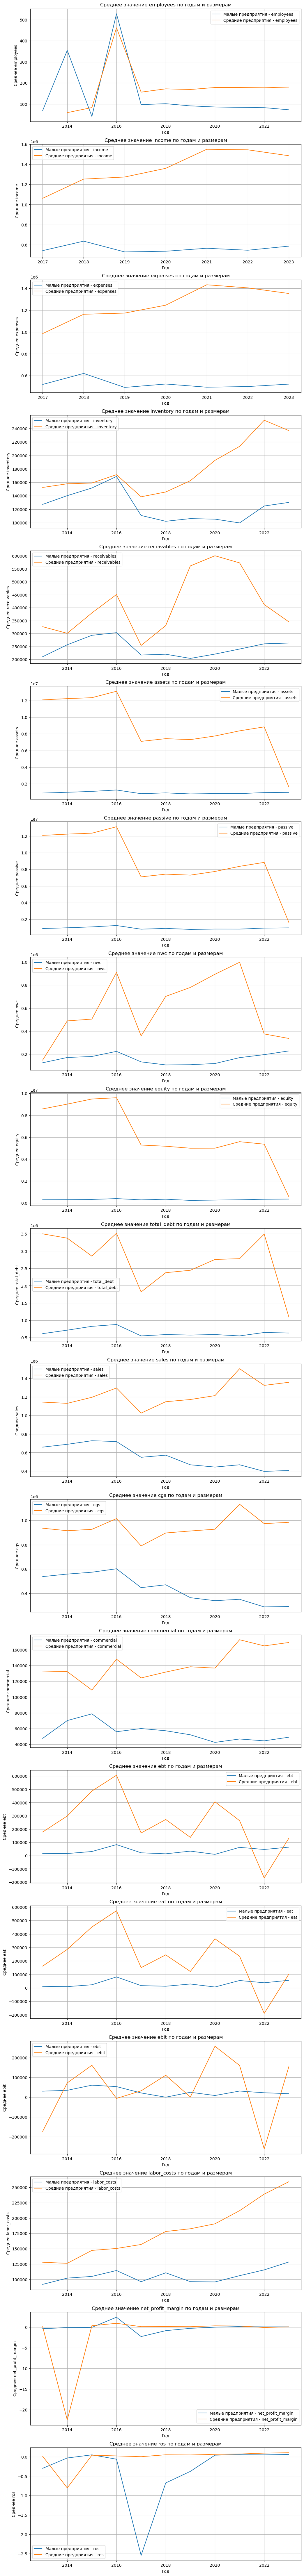

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
# Ensure all financial columns are numeric
for col in financial_columns:
    df_msp[col] = pd.to_numeric(df_msp[col], errors='coerce')

# 6. Расчет статистик для ВСЕХ финансовых показателей
financial_stats = calculate_yearly_stats(groups_year_size, financial_columns)

# 7. Добавление p-value (сравнение размеров *внутри каждого года* и *для каждого показателя*)
for year in financial_stats['Год'].unique():
    year_data = financial_stats[financial_stats['Год'] == year]
    if len(year_data) > 1:
        small_data = year_data[year_data['Размер'] == 'Малые предприятия']
        medium_data = year_data[year_data['Размер'] == 'Средние предприятия']
      
        if small_data.empty or medium_data.empty:
          continue

        # Сравниваем средние для каждого показателя
        p_values = []
        for col in financial_columns:
            small_mean = small_data[f'{col}_Среднее']
            medium_mean = medium_data[f'{col}_Среднее']
          
            if small_mean.isna().all() or medium_mean.isna().all():  # Если все значения NaN для столбца
                p_values.append(np.nan) # то и p-value = NaN
                continue  # Пропускаем этот столбец
                
            t_stat, p_value = stats.ttest_ind(small_mean.astype(float), medium_mean.astype(float), equal_var=False, nan_policy='omit')
            p_values.append(p_value)

        # Находим минимальное p-value среди всех показателей
        min_p_value = np.nanmin(p_values) if p_values else np.nan

         # Записываем МИНИМАЛЬНОЕ p-value
        financial_stats.loc[(financial_stats['Год'] == year) & (financial_stats['Размер'] == 'Средние предприятия'), 'p-value'] = min_p_value


# 8. Вывод статистической таблицы (пример для нескольких столбцов)
print("Статистическая таблица (часть):")
print(financial_stats.head(20).to_string())  # Выводим первые 20 строк для примера

# 9. Вывод ПОЛНОЙ таблицы в файл (чтобы не загромождать вывод)
with open('financial_stats_full.txt', 'w') as f:
    f.write(financial_stats.to_string())
print("\nПолная таблица записана в файл 'financial_stats_full.txt'")


# 10. Визуализация (пример: lineplot для income и equity)
fig, axes = plt.subplots(nrows=len(financial_columns), ncols=1, figsize=(12, 6 * len(financial_columns)))

if len(financial_columns) == 1:
    axes = [axes]

for i, col in enumerate(financial_columns):
    ax = axes[i]
    for size in financial_stats['Размер'].unique():
        size_data = financial_stats[financial_stats['Размер'] == size]
        ax.plot(size_data['Год'], size_data[f'{col}_Среднее'], label=f'{size} - {col}')

    ax.set_title(f'Среднее значение {col} по годам и размерам')
    ax.set_xlabel('Год')
    plt.figure()
    ax.set_ylabel(f'Среднее {col}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

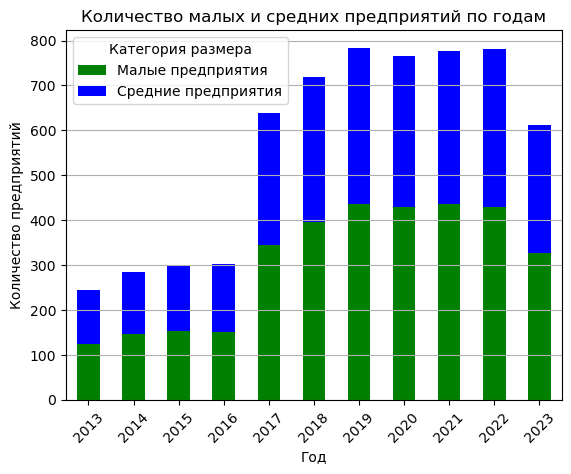

In [19]:
# Группировка данных по годам и категориям размера
size_counts_by_year = df_msp.groupby(['year', 'size_cat']).size().unstack(fill_value=0)

# Построение графика
plt.figure(figsize=(12, 8))
size_counts_by_year.plot(kind='bar', stacked=True, color=['green', 'blue'])
plt.title('Количество малых и средних предприятий по годам')
plt.xlabel('Год')
plt.ylabel('Количество предприятий')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Категория размера')
plt.show()

/tmp/ipykernel_202433/1973140912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp['employees'] = pd.to_numeric(df_msp['employees'], errors='coerce')


<Figure size 1200x800 with 0 Axes>

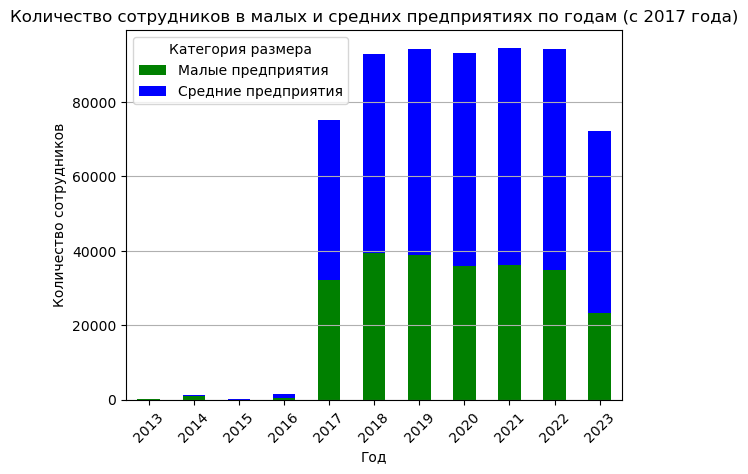

In [20]:
# Ensure 'employees' column is numeric
df_msp['employees'] = pd.to_numeric(df_msp['employees'], errors='coerce')

# Группировка данных по годам и категориям размера
employees_counts_by_year = df_msp.groupby(['year', 'size_cat'])['employees'].sum().unstack(fill_value=0)

# Построение графика
plt.figure(figsize=(12, 8))
employees_counts_by_year.plot(kind='bar', stacked=True, color=['green', 'blue'])
plt.title('Количество сотрудников в малых и средних предприятиях по годам (с 2017 года)')
plt.xlabel('Год')
plt.ylabel('Количество сотрудников')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Категория размера')
plt.show()

In [21]:
def calculate_and_save_mean_financials(df, financial_columns, output_file="mean_financials_dataset.csv"):
    # Группировка данных по компаниям
    grouped_companies = df.groupby('Компания')

    # Функция для расчета среднего значения финансовых показателей
    def calculate_mean_financials(group):
        mean_financials = group[financial_columns].mean().round()
        first_row = group.iloc[0].drop(financial_columns)
        return pd.concat([first_row, mean_financials])

    # Применение функции к каждой группе и создание нового датасета
    mean_financials_df = grouped_companies.apply(calculate_mean_financials).reset_index(drop=True)

    # Сохранение нового датасета
    mean_financials_df.to_csv(output_file, index=False)
    return mean_financials_df

# Вызов функции
mean_financials_df = calculate_and_save_mean_financials(df_msp, financial_columns)
print("Новый датасет со средними значениями финансовых показателей создан и сохранен в 'mean_financials_dataset.csv'.")
print(mean_financials_df.head())

Новый датасет со средними значениями финансовых показателей создан и сохранен в 'mean_financials_dataset.csv'.
                                            Компания            Город  \
0                                           1С-Рарус           Москва   
1                   А-фарм, фармацевтических холдинг           Москва   
2  АВТЭК (Автотранспортная топливно-энергетическа...           Москва   
3         АМКК (Армавирский мясоконсервный комбинат)          Армавир   
4                               АНТ-Цифровые Сервисы  Санкт-Петербург   

                        name            region.y  \
0              1С-РАРУС, ООО              Москва   
1                А-ФАРМ, ООО              Москва   
2                  АВТЭК, АО              Москва   
3                  АМКК, ООО  Краснодарский край   
4  АНТ-ЦИФРОВЫЕ СЕРВИСЫ, ООО     Санкт-Петербург   

                                            industry             size_cat  \
0  Разработка компьютерного программного обеспечения  Средни

In [22]:
# Группировка данных по компаниям
grouped_companies = df_msp.groupby('Компания')

columns_to_drop = [
    'Технология', 'Продукт'
]


# Функция для расчета среднего значения финансовых показателей
def calculate_mean_financials(group):
    mean_financials = group[financial_columns].mean().round()
    first_row = group.iloc[0].drop(financial_columns)
    return pd.concat([first_row, mean_financials])

# Применение функции к каждой группе и создание нового датасета
mean_financials_df = grouped_companies.apply(calculate_mean_financials).reset_index(drop=True)

mean_financials_df = mean_financials_df.drop(columns=columns_to_drop)
# Сохранение нового датасета
mean_financials_df.to_csv("mean_financials_dataset.csv", index=False)

print("Новый датасет со средними значениями финансовых показателей создан и сохранен в 'mean_financials_dataset.csv'.")
print(mean_financials_df.head())

Новый датасет со средними значениями финансовых показателей создан и сохранен в 'mean_financials_dataset.csv'.
                                            Компания            Город  \
0                                           1С-Рарус           Москва   
1                   А-фарм, фармацевтических холдинг           Москва   
2  АВТЭК (Автотранспортная топливно-энергетическа...           Москва   
3         АМКК (Армавирский мясоконсервный комбинат)          Армавир   
4                               АНТ-Цифровые Сервисы  Санкт-Петербург   

                        name            region.y  \
0              1С-РАРУС, ООО              Москва   
1                А-ФАРМ, ООО              Москва   
2                  АВТЭК, АО              Москва   
3                  АМКК, ООО  Краснодарский край   
4  АНТ-ЦИФРОВЫЕ СЕРВИСЫ, ООО     Санкт-Петербург   

                                            industry             size_cat  \
0  Разработка компьютерного программного обеспечения  Средни

In [23]:
# Фильтрация малых предприятий с количеством сотрудников больше 100
small_companies = mean_financials_df[(mean_financials_df['size_cat'] == 'Малые предприятия') & (mean_financials_df['employees'] > 100)]

# Фильтрация средних предприятий с количеством сотрудников больше 250
medium_companies = mean_financials_df[(mean_financials_df['size_cat'] == 'Средние предприятия') & (mean_financials_df['employees'] > 250)]

# Вывод списка компаний
print("Компании малых предприятий с количеством сотрудников больше 100:")
print(small_companies[['Компания', 'employees']])

print("\nКомпании средних предприятий с количеством сотрудников больше 250:")
print(medium_companies[['Компания', 'employees']])


# Удаление компаний, у которых количество сотрудников больше 250
companies_to_remove = mean_financials_df[mean_financials_df['employees'] > 250]['Компания'].unique()
df_msp = df_msp[~df_msp['Компания'].isin(companies_to_remove)]

# Удаление малых предприятий, у которых количество сотрудников больше 100
small_companies_to_remove = mean_financials_df[(mean_financials_df['size_cat'] == 'Малые предприятия') & (mean_financials_df['employees'] > 100)]['Компания'].unique()
df_msp = df_msp[~df_msp['Компания'].isin(small_companies_to_remove)]

print(f"Удалено компаний с количеством сотрудников больше 250: {len(companies_to_remove)}")
print(f"Удалено малых предприятий с количеством сотрудников больше 100: {len(small_companies_to_remove)}")

Компании малых предприятий с количеством сотрудников больше 100:
                                              Компания  employees
2    АВТЭК (Автотранспортная топливно-энергетическа...      107.0
9                                           АЭС инвест      157.0
19                                          Автоделюкс      213.0
27                     Агропредприятие Бессергеневское      122.0
31                                 Агрофирма Металлург      368.0
..                                                 ...        ...
770                           Энергомаш (Чехов) – ЧЗЭМ      505.0
773                                    Эннова (Ennova)      241.0
775                                      Этреко-Сервис      129.0
783                  Юнайтед Термо Рус (United Thermo)      102.0
785                                       Юнико Металл      205.0

[131 rows x 2 columns]

Компании средних предприятий с количеством сотрудников больше 250:
                        Компания  employees
7      

In [24]:
mean_financials_df = calculate_and_save_mean_financials(df_msp, financial_columns)

In [25]:
columns_to_drop = [
    'Технология', 'Продукт'
]

mean_financials_df = mean_financials_df.drop(columns=columns_to_drop)
mean_financials_df.to_csv("mean_financials_dataset.csv", index=False)

In [26]:
# Вычисляем границы для удаления компаний
mean_sales = mean_financials_df.groupby('size_cat')['sales'].mean()
std_sales = mean_financials_df.groupby('size_cat')['sales'].std()

mean_ros = mean_financials_df.groupby('size_cat')['ros'].mean()
std_ros = mean_financials_df.groupby('size_cat')['ros'].std()

# Определяем верхнюю границу
upper_limit = mean_sales + 2 * std_sales
down_limit_ros = mean_ros - 2 * std_ros

# Фильтруем компании, которые превышают верхнюю границу
companies_to_remove = mean_financials_df[
    (mean_financials_df['sales'] > mean_financials_df['size_cat'].map(upper_limit)) |
    (mean_financials_df['ros'] < mean_financials_df['size_cat'].map(down_limit_ros))
]['Компания'].unique()

# Удаляем компании из df_msp
mean_financials_df = mean_financials_df[~mean_financials_df['Компания'].isin(companies_to_remove)]
df_msp = df_msp[~df_msp['Компания'].isin(companies_to_remove)]

print(f"Удалено компаний: {len(companies_to_remove)}")

Удалено компаний: 20


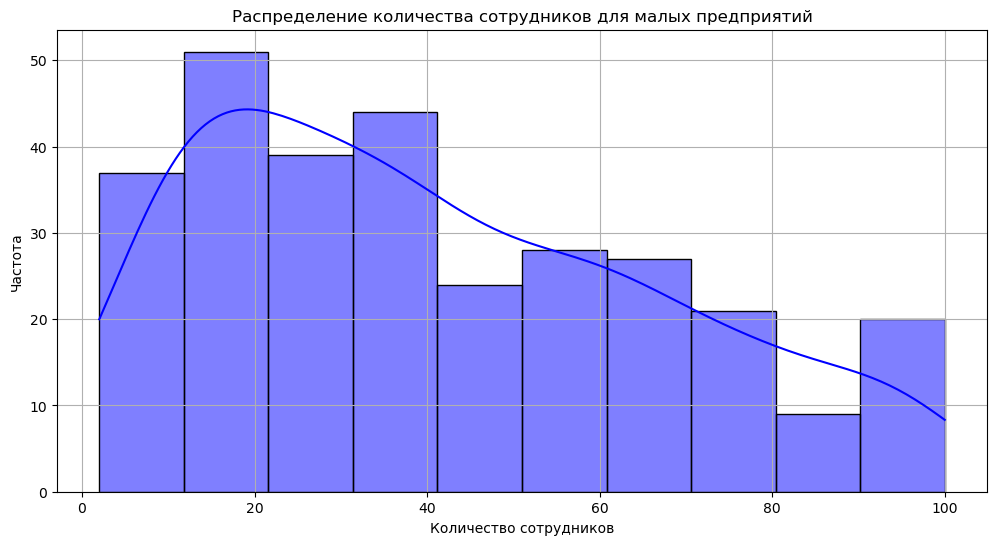

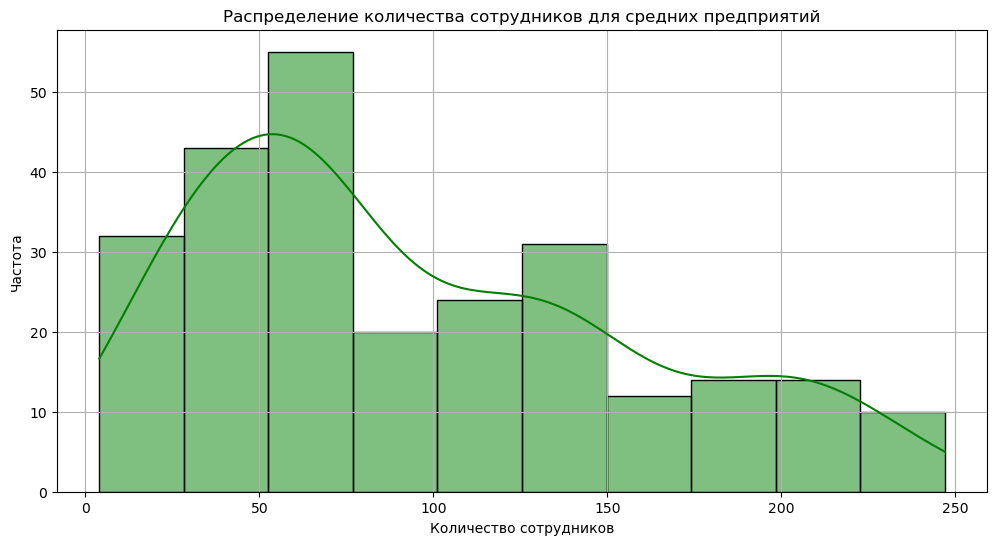

In [27]:
import seaborn as sns

# Фильтрация данных для малых и средних предприятий
small_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Малые предприятия']
medium_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Средние предприятия']

# Построение распределения для малых предприятий
plt.figure(figsize=(12, 6))
sns.histplot(small_enterprises['employees'], kde=True, bins=10, color='blue')
plt.title('Распределение количества сотрудников для малых предприятий')
plt.xlabel('Количество сотрудников')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Построение распределения для средних предприятий
plt.figure(figsize=(12, 6))
sns.histplot(medium_enterprises['employees'], kde=True, bins=10, color='green')
plt.title('Распределение количества сотрудников для средних предприятий')
plt.xlabel('Количество сотрудников')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

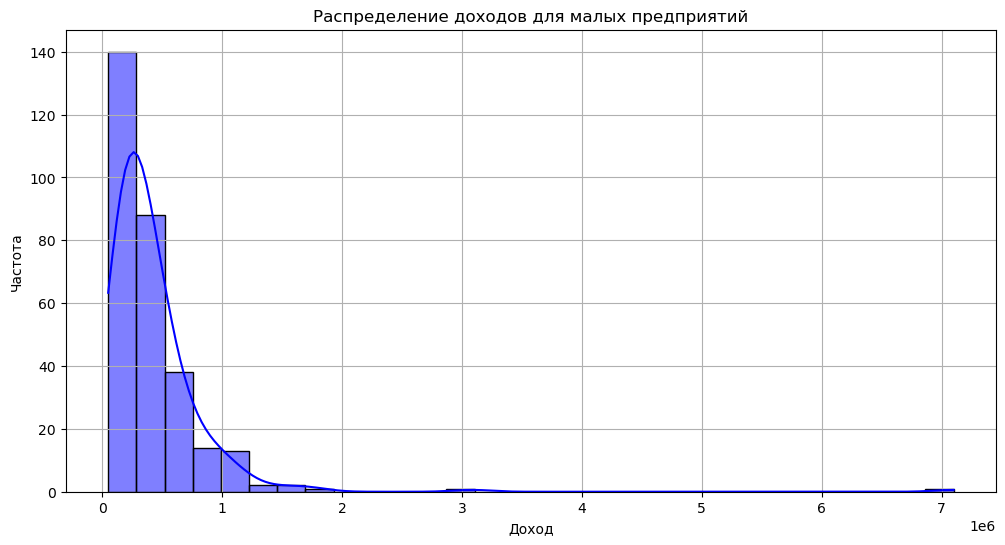

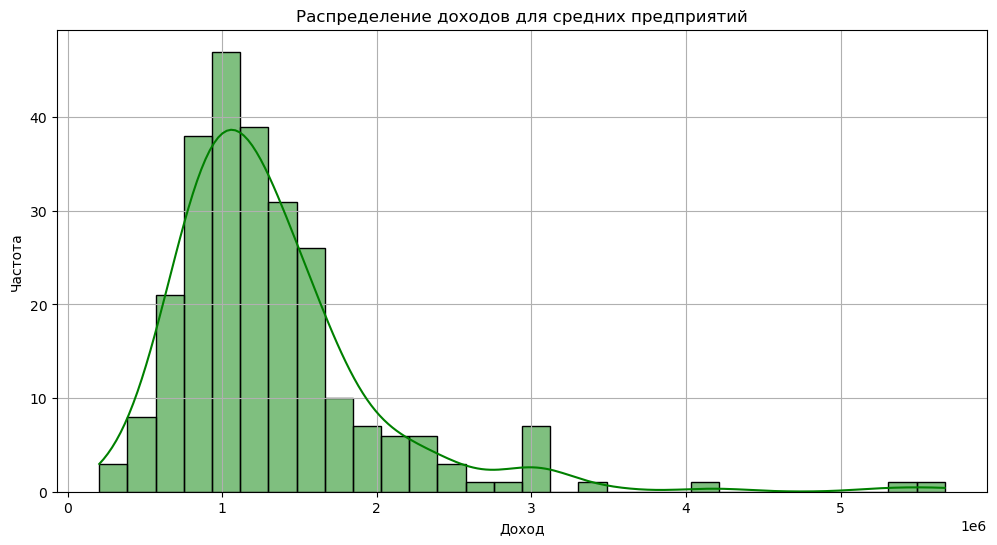

In [28]:
import seaborn as sns

# Фильтрация данных для малых и средних предприятий
small_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Малые предприятия']
medium_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Средние предприятия']

# Построение распределения для малых предприятий
plt.figure(figsize=(12, 6))
sns.histplot(small_enterprises['income'], kde=True, bins=30, color='blue')
plt.title('Распределение доходов для малых предприятий')
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Построение распределения для средних предприятий
plt.figure(figsize=(12, 6))
sns.histplot(medium_enterprises['income'], kde=True, bins=30, color='green')
plt.title('Распределение доходов для средних предприятий')
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

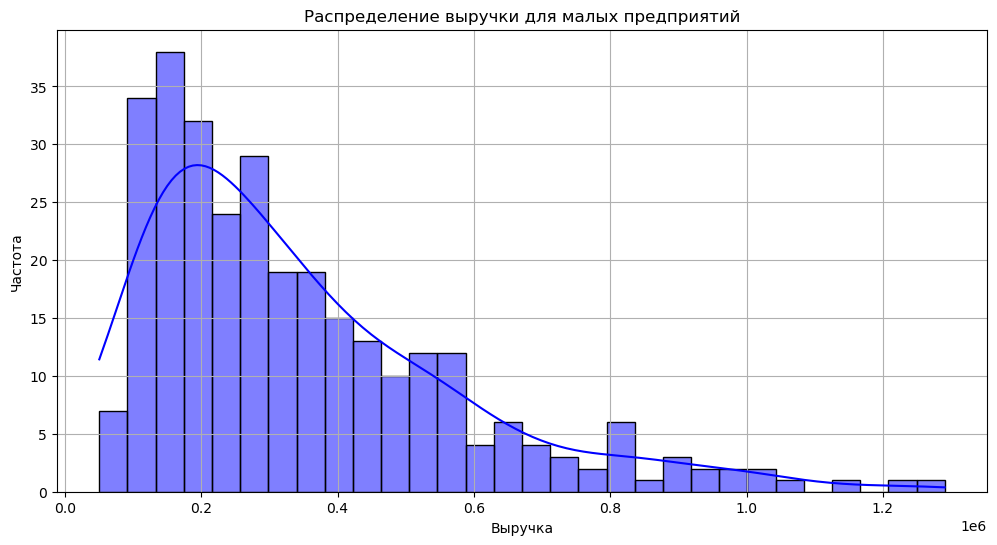

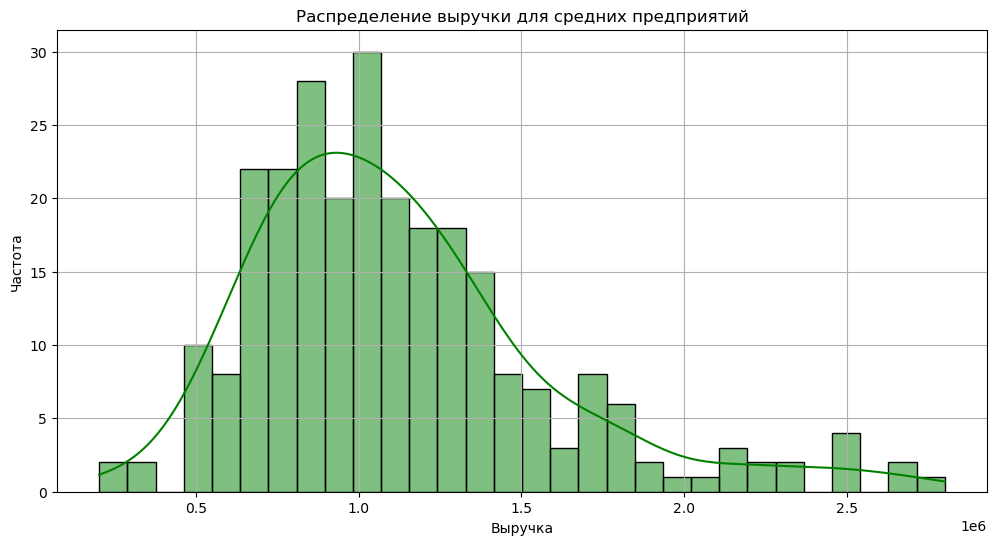

In [29]:
import seaborn as sns

# Фильтрация данных для малых и средних предприятий
small_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Малые предприятия']
medium_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Средние предприятия']

# Построение распределения для малых предприятий
plt.figure(figsize=(12, 6))
sns.histplot(small_enterprises['sales'], kde=True, bins=30, color='blue')
plt.title('Распределение выручки для малых предприятий')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Построение распределения для средних предприятий
plt.figure(figsize=(12, 6))
sns.histplot(medium_enterprises['sales'], kde=True, bins=30, color='green')
plt.title('Распределение выручки для средних предприятий')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

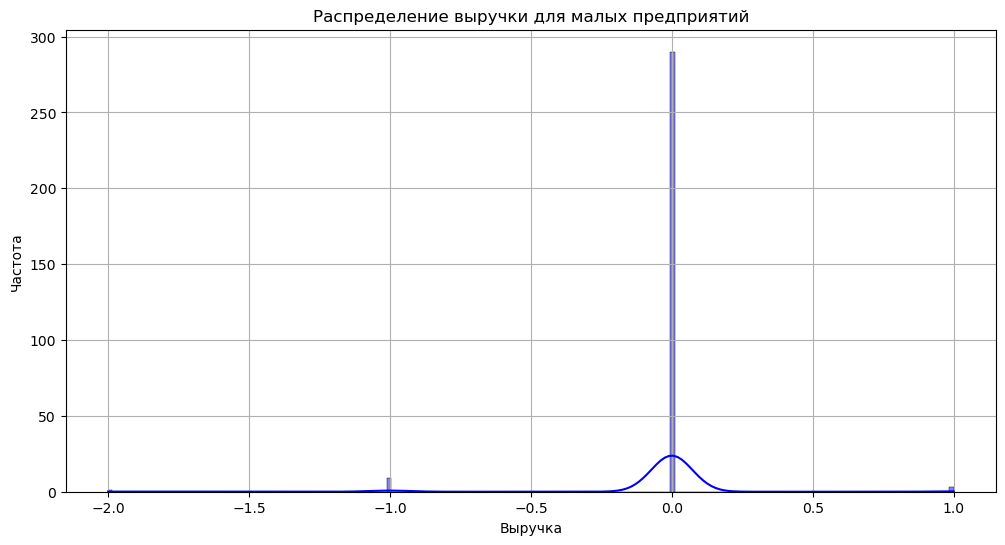

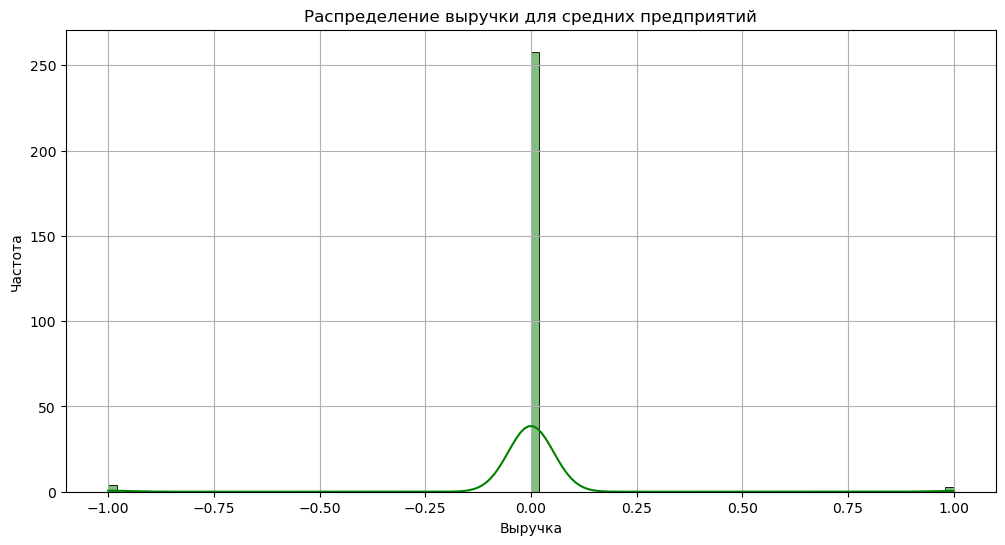

In [30]:
import seaborn as sns

# Фильтрация данных для малых и средних предприятий
small_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Малые предприятия']
medium_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Средние предприятия']

# Построение распределения для малых предприятий
plt.figure(figsize=(12, 6))
sns.histplot(small_enterprises['ros'], kde=True, bins=200, color='blue')
plt.title('Распределение выручки для малых предприятий')
# plt.xlim(-1000000, 1000000)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Построение распределения для средних предприятий
plt.figure(figsize=(12, 6))
sns.histplot(medium_enterprises['ros'], kde=True, bins=100, color='green')
plt.title('Распределение выручки для средних предприятий')
# plt.xlim(-10000000, 10000000)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [31]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display, HTML

# Define financial_columns
# financial_columns = ['income', 'expenses', 'lt_debt', 'st_debt', 'sales', 'cgs', 'commercial', 'eat', 'labor_costs']

# Function to display the comparison table in a more readable format
def display_comparison_table(df):
    display(HTML(df.to_html(index=False)))

# Function to calculate p-values and other statistics for each financial indicator
def calculate_statistics(df, financial_columns):
    statistics = {}
    for col in financial_columns:
        small_values = df[df['size_cat'] == 'Малые предприятия'][col].dropna()
        medium_values = df[df['size_cat'] == 'Средние предприятия'][col].dropna()
        
        if len(small_values) > 1 and len(medium_values) > 1:
            t_stat, p_value = stats.ttest_ind(small_values, medium_values, equal_var=False, nan_policy='omit')
            statistics[col] = {
                'p_value': round(p_value, 2),
                'small_mean': round(small_values.mean(), 2),
                'medium_mean': round(medium_values.mean(), 2),
                'small_std': round(small_values.std(), 2),
                'medium_std': round(medium_values.std(), 2)
            }
        else:
            statistics[col] = {
                'p_value': np.nan,
                'small_mean': np.nan,
                'medium_mean': np.nan,
                'small_std': np.nan,
                'medium_std': np.nan
            }
    return statistics

# Function to add significance stars
def add_significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''
# Где *** - p-value < 0.01, ** - p-value < 0.05, * - p-value < 0.1

# Calculate statistics for each financial indicator
statistics = calculate_statistics(mean_financials_df, financial_columns)

# Create a table with mean values, p-values, and other statistics
comparison_table = pd.DataFrame(columns=['Показатель', 'Среднее (Малые предприятия)', 'Среднее (Средние предприятия)', 'Значимость'])

for col in financial_columns:
    new_row = pd.DataFrame({
        'Показатель': [col],
        'Среднее (Малые предприятия)': [f"{statistics[col]['small_mean']} ({statistics[col]['small_std']})"],
        'Среднее (Средние предприятия)': [f"{statistics[col]['medium_mean']} ({statistics[col]['medium_std']})"],
        'Значимость': [add_significance_stars(statistics[col]['p_value'])]
    })
    comparison_table = pd.concat([comparison_table, new_row], ignore_index=True)

# Print the table
print(comparison_table)

# Save the table to a file
comparison_table.to_csv("comparison_table.csv", index=False)
print("Таблица сравнений сохранена в 'comparison_table.csv'.")


           Показатель Среднее (Малые предприятия)  \
0           employees               41.14 (26.21)   
1              income       423820.94 (505043.79)   
2            expenses       373815.22 (290311.88)   
3           inventory         65215.76 (89510.56)   
4         receivables        155627.71 (383114.6)   
5              assets      613818.88 (1707765.67)   
6             passive      613785.43 (1707770.03)   
7                 nwc       110268.42 (279136.51)   
8              equity      295250.84 (1236871.39)   
9          total_debt       333720.04 (753893.67)   
10              sales        344987.7 (230921.43)   
11                cgs       253244.46 (191291.56)   
12         commercial         35772.92 (44411.07)   
13                ebt        48761.94 (345063.33)   
14                eat        44164.91 (341903.81)   
15               ebit         23065.57 (70562.35)   
16        labor_costs          59747.9 (73112.82)   
17  net_profit_margin                 0.15 (3.

In [32]:
# Function to calculate statistics for each financial indicator
def calculate_extended_statistics(df, financial_columns):
    extended_statistics = {}
    for col in financial_columns:
        small_values = df[df['size_cat'] == 'Малые предприятия'][col].dropna()
        medium_values = df[df['size_cat'] == 'Средние предприятия'][col].dropna()
        
        if len(small_values) > 1 and len(medium_values) > 1:
            extended_statistics[col] = {
                'small_min': round(small_values.min(), 2),
                'small_max': round(small_values.max(), 2),
                'small_count': len(small_values),
                'small_mean': round(small_values.mean(), 2),
                'medium_min': round(medium_values.min(), 2),
                'medium_max': round(medium_values.max(), 2),
                'medium_count': len(medium_values),
                'medium_mean': round(medium_values.mean(), 2)
            }
        else:
            extended_statistics[col] = {
                'small_min': np.nan,
                'small_max': np.nan,
                'small_count': np.nan,
                'small_mean': np.nan,
                'medium_min': np.nan,
                'medium_max': np.nan,
                'medium_count': np.nan,
                'medium_mean': np.nan
            }
    return extended_statistics

# Calculate extended statistics for each financial indicator
extended_statistics = calculate_extended_statistics(mean_financials_df, financial_columns)

# Create a table with min, max, count, and mean values for each financial indicator
extended_comparison_table = pd.DataFrame(columns=['Показатель', 'Минимум (Малые предприятия)', 'Максимум (Малые предприятия)', 'Количество (Малые предприятия)', 'Среднее (Малые предприятия)', 'Минимум (Средние предприятия)', 'Максимум (Средние предприятия)', 'Количество (Средние предприятия)', 'Среднее (Средние предприятия)'])

for col in financial_columns:
    new_row = pd.DataFrame({
        'Показатель': [col],
        'Минимум (Малые предприятия)': [extended_statistics[col]['small_min']],
        'Максимум (Малые предприятия)': [extended_statistics[col]['small_max']],
        'Количество (Малые предприятия)': [extended_statistics[col]['small_count']],
        'Среднее (Малые предприятия)': [extended_statistics[col]['small_mean']],
        'Минимум (Средние предприятия)': [extended_statistics[col]['medium_min']],
        'Максимум (Средние предприятия)': [extended_statistics[col]['medium_max']],
        'Количество (Средние предприятия)': [extended_statistics[col]['medium_count']],
        'Среднее (Средние предприятия)': [extended_statistics[col]['medium_mean']]
    })
    extended_comparison_table = pd.concat([extended_comparison_table, new_row], ignore_index=True)

# Print the extended comparison table
extended_comparison_table

# Save the extended comparison table to a file
extended_comparison_table.to_csv("extended_comparison_table.csv", index=False)
print("Расширенная таблица сравнений сохранена в 'extended_comparison_table.csv'.")

Расширенная таблица сравнений сохранена в 'extended_comparison_table.csv'.


/tmp/ipykernel_202433/209037974.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extended_comparison_table = pd.concat([extended_comparison_table, new_row], ignore_index=True)


In [33]:
# Display the comparison table
display_comparison_table(comparison_table)

Показатель,Среднее (Малые предприятия),Среднее (Средние предприятия),Значимость
employees,41.14 (26.21),95.69 (62.61),***
income,423820.94 (505043.79),1319686.31 (691123.27),***
expenses,373815.22 (290311.88),1185867.35 (558413.77),***
inventory,65215.76 (89510.56),171307.3 (209746.43),***
receivables,155627.71 (383114.6),507570.46 (3226474.52),*
assets,613818.88 (1707765.67),1557829.42 (5643525.6),**
passive,613785.43 (1707770.03),1557829.42 (5643525.6),**
nwc,110268.42 (279136.51),379311.8 (2331822.28),*
equity,295250.84 (1236871.39),644541.92 (3260215.03),
total_debt,333720.04 (753893.67),987460.45 (4846149.79),**


In [34]:
extended_comparison_table

,Показатель,Минимум (Малые предприятия),Максимум (Малые предприятия),Количество (Малые предприятия),Среднее (Малые предприятия),Минимум (Средние предприятия),Максимум (Средние предприятия),Количество (Средние предприятия),Среднее (Средние предприятия)
0,employees,2.0,100.0,300,41.14,4.0,247.0,255,95.69
1,income,50418.0,7099680.0,300,423820.94,204660.0,5674405.0,258,1319686.31
2,expenses,44654.0,1804761.0,300,373815.22,114225.0,4234344.0,258,1185867.35
3,inventory,1.0,755958.0,303,65215.76,70.0,1905046.0,264,171307.30
4,receivables,4962.0,3574302.0,303,155627.71,7231.0,52313910.0,265,507570.46
5,assets,16149.0,23018178.0,303,613818.88,101457.0,75081673.0,265,1557829.42
6,passive,16149.0,23018178.0,303,613785.43,101457.0,75081673.0,265,1557829.42
7,nwc,-752845.0,2326890.0,303,110268.42,-2588851.0,37100658.0,265,379311.80
8,equity,-212041.0,18558875.0,303,295250.84,-2774382.0,47897948.0,265,644541.92
9,total_debt,8777.0,5969972.0,303,333720.04,22157.0,76672275.0,265,987460.45


In [35]:
comparison_table

,Показатель,Среднее (Малые предприятия),Среднее (Средние предприятия),Значимость
0,employees,41.14 (26.21),95.69 (62.61),***
1,income,423820.94 (505043.79),1319686.31 (691123.27),***
2,expenses,373815.22 (290311.88),1185867.35 (558413.77),***
3,inventory,65215.76 (89510.56),171307.3 (209746.43),***
4,receivables,155627.71 (383114.6),507570.46 (3226474.52),*
5,assets,613818.88 (1707765.67),1557829.42 (5643525.6),**
6,passive,613785.43 (1707770.03),1557829.42 (5643525.6),**
7,nwc,110268.42 (279136.51),379311.8 (2331822.28),*
8,equity,295250.84 (1236871.39),644541.92 (3260215.03),
9,total_debt,333720.04 (753893.67),987460.45 (4846149.79),**


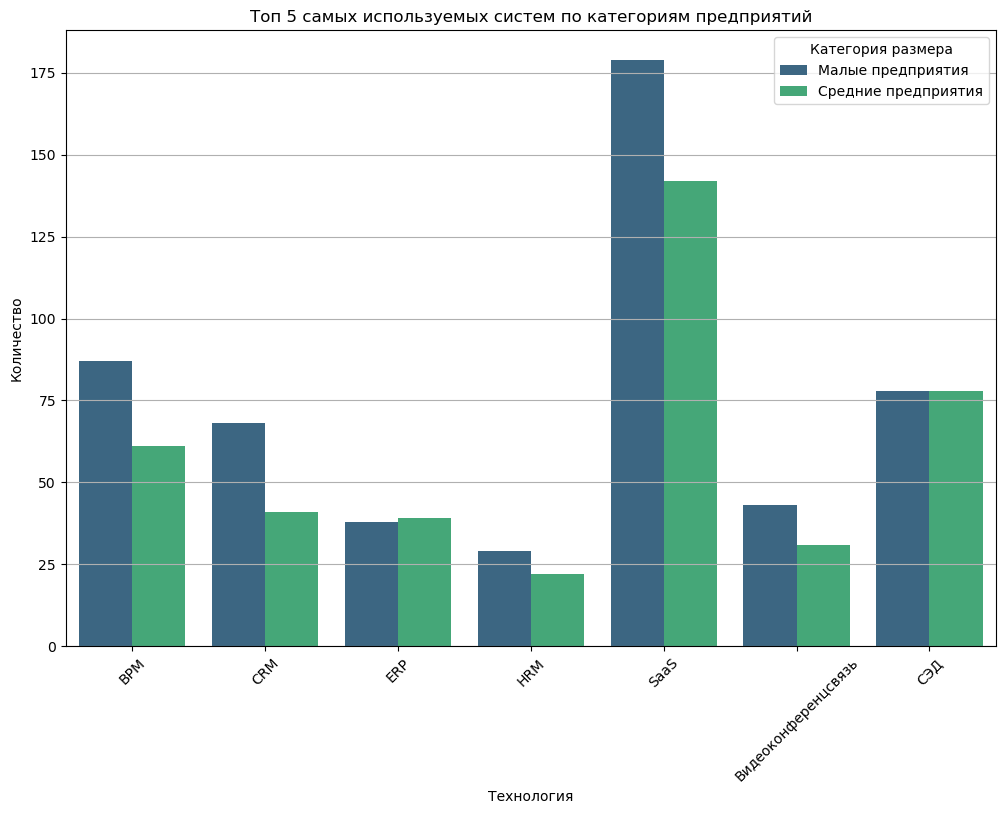

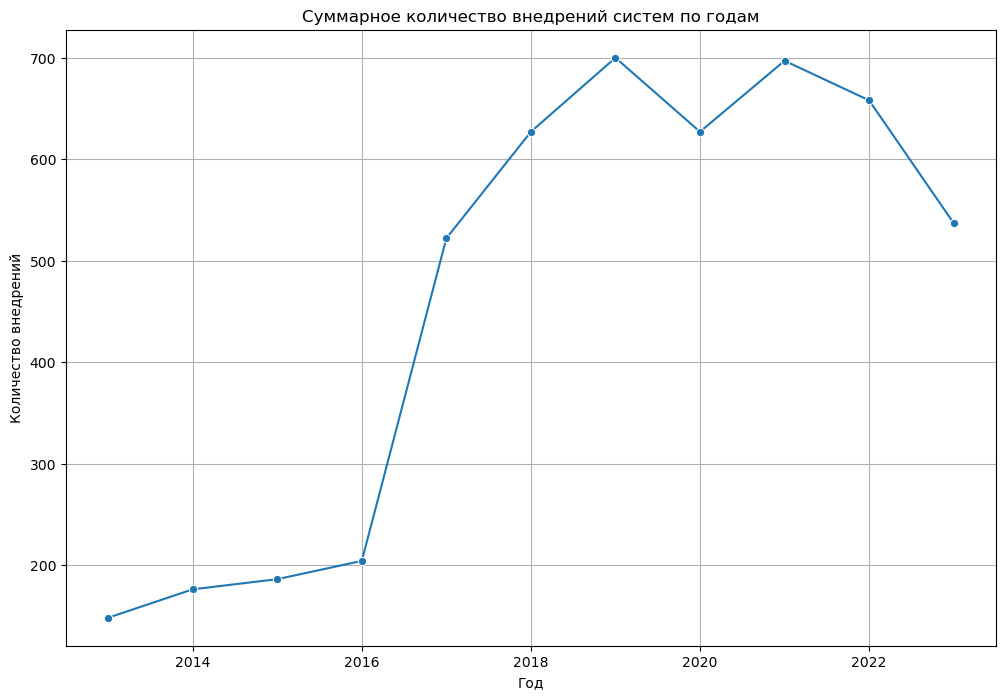

/tmp/ipykernel_202433/645010925.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_technology_counts.head(10), x='ind', y='total_counts', palette='viridis')


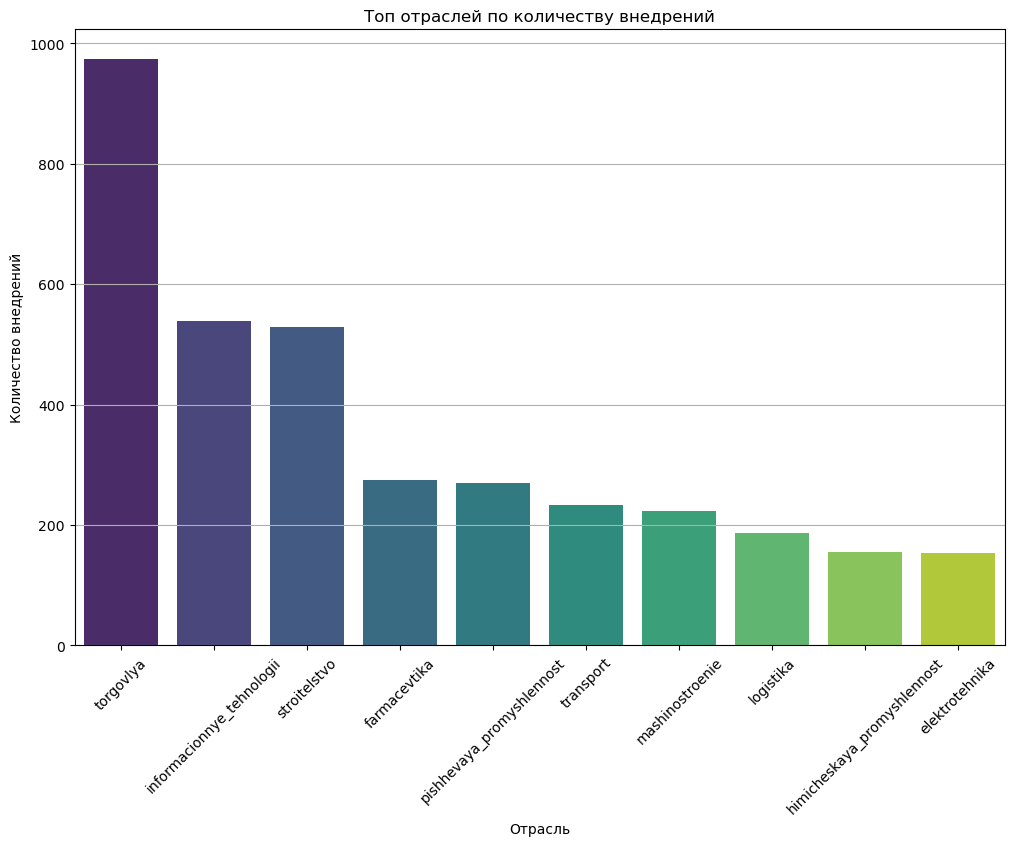

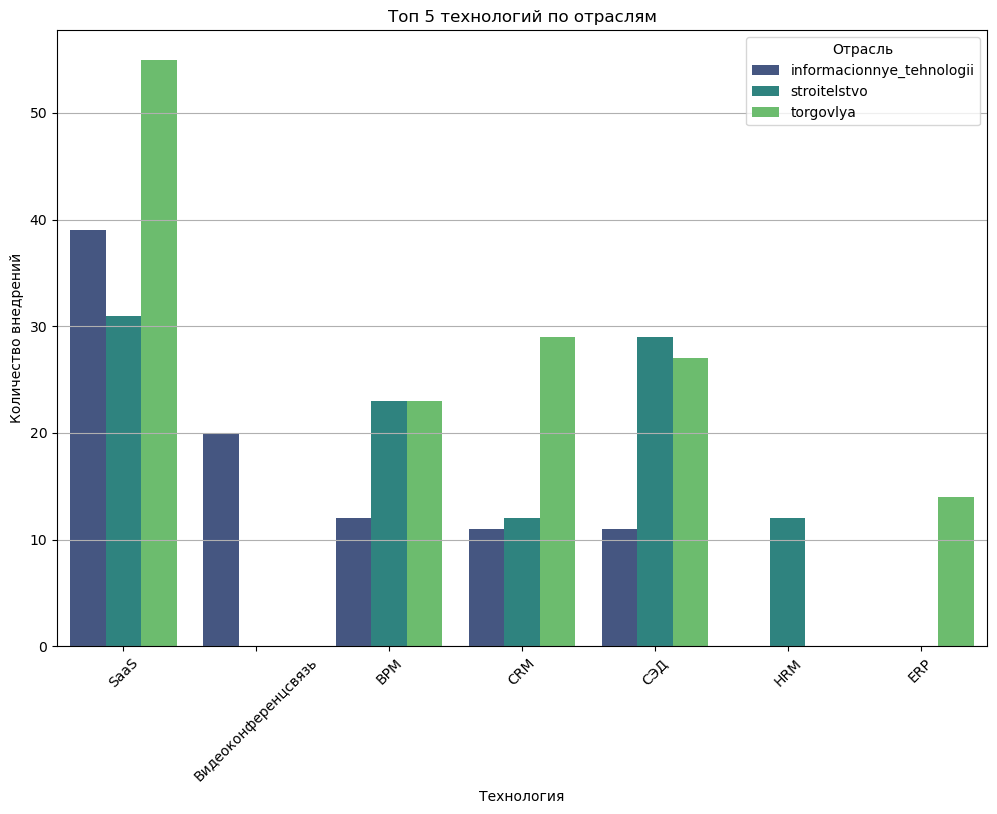

In [36]:
# Ensure the column names are correct
if 'firts_number_okved' in df_msp.columns and 'Технология' in df_msp.columns:
    # Convert 'firts_number_okved' to string if it's not already
    df_msp['firts_number_okved'] = df_msp['firts_number_okved'].astype(str)
    
    # Split the 'Технология' column by commas and explode the dataframe
    df_exploded = df_msp.assign(Технология=df_msp['Технология'].str.split(',')).explode('Технология')
    
    # Группировка по Технология и size_cat и суммирование
    technology_counts = df_exploded.groupby(['Технология', 'size_cat']).size().reset_index(name='counts')
    
    # Получение топ 5 самых используемых систем
    top_5_technologies = technology_counts.groupby('Технология')['counts'].sum().nlargest(7).index
    top_5_technology_counts = technology_counts[technology_counts['Технология'].isin(top_5_technologies)]
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_5_technology_counts, x='Технология', y='counts', hue='size_cat', palette='viridis')
    plt.title('Топ 5 самых используемых систем по категориям предприятий')
    plt.xlabel('Технология')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(title='Категория размера')
    plt.show()
    
    # Группировка по годам и суммирование количества внедрений
    yearly_technology_counts = df_exploded.groupby('year').size().reset_index(name='counts')
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=yearly_technology_counts, x='year', y='counts', marker='o')
    plt.title('Суммарное количество внедрений систем по годам')
    plt.xlabel('Год')
    plt.ylabel('Количество внедрений')
    plt.grid(True)
    plt.show()
    
    # Группировка по отрасли (ind) и суммирование количества внедрений для каждой компании
    industry_technology_counts = df_exploded.groupby(['Компания', 'ind']).size().reset_index(name='counts')
    
    # Суммирование количества внедрений по отраслям
    industry_technology_counts = industry_technology_counts.groupby('ind')['counts'].sum().reset_index(name='total_counts').sort_values(by='total_counts', ascending=False)
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=industry_technology_counts.head(10), x='ind', y='total_counts', palette='viridis')
    plt.title('Топ отраслей по количеству внедрений')
    plt.xlabel('Отрасль')
    plt.ylabel('Количество внедрений')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()
    
    # Группировка по отраслям и технологиям, суммирование количества внедрений
    industry_technology_counts = df_exploded.groupby(['ind', 'Технология']).size().reset_index(name='counts')
    
    # Получение топ 3 отраслей
    top_3_industries = industry_technology_counts.groupby('ind')['counts'].sum().nlargest(3).index
    
    # Фильтрация данных для топ 3 отраслей
    top_3_industry_technology_counts = industry_technology_counts[industry_technology_counts['ind'].isin(top_3_industries)]
    
    # Получение топ 5 технологий для каждой отрасли
    top_5_technologies_by_industry = top_3_industry_technology_counts.groupby('ind').apply(lambda x: x.nlargest(5, 'counts')).reset_index(drop=True)
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_5_technologies_by_industry, x='Технология', y='counts', hue='ind', palette='viridis')
    plt.title('Топ 5 технологий по отраслям')
    plt.xlabel('Технология')
    plt.ylabel('Количество внедрений')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(title='Отрасль')
    plt.show()
else:
    print("One or both columns 'firts_number_okved' and 'Технология' do not exist in the DataFrame.")


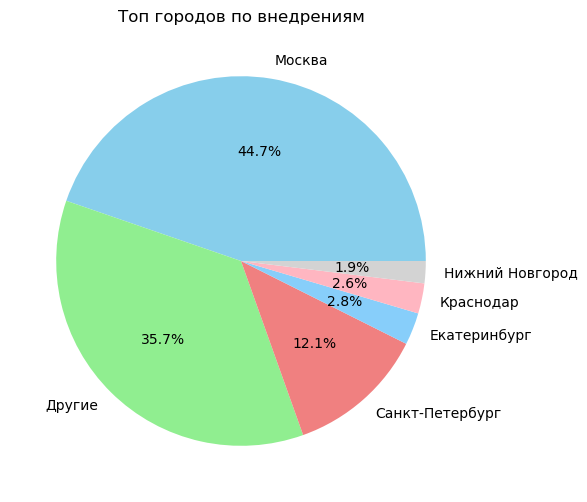

In [37]:
# Подсчет общего количества каждого города
city_counts = mean_financials_df['Город'].value_counts()

# Выбор топ 5 городов
top_5_cities = city_counts.head(5)

# Создание новой категории "Другие" для всех остальных городов
mean_financials_df['Город'] = mean_financials_df['Город'].apply(lambda x: x if x in top_5_cities.index else 'Другие')

# Подсчет количества компаний в каждом городе, включая категорию "Другие"
city_counts = mean_financials_df['Город'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(10, 6))
city_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'lightgray'])
plt.title('Топ городов по внедрениям')
plt.ylabel('')  # Убираем метку оси y
plt.show()

In [38]:
print(df_msp.head())

    Компания   Город           name region.y  \
21  1С-Рарус  Москва  1С-РАРУС, ООО   Москва   
22  1С-Рарус  Москва  1С-РАРУС, ООО   Москва   
23  1С-Рарус  Москва  1С-РАРУС, ООО   Москва   
24  1С-Рарус  Москва  1С-РАРУС, ООО   Москва   
25  1С-Рарус  Москва  1С-РАРУС, ООО   Москва   

                                             industry             size_cat  \
21  Разработка компьютерного программного обеспечения  Средние предприятия   
22  Разработка компьютерного программного обеспечения  Средние предприятия   
23  Разработка компьютерного программного обеспечения  Средние предприятия   
24  Разработка компьютерного программного обеспечения  Средние предприятия   
25  Разработка компьютерного программного обеспечения  Средние предприятия   

    employees    income  expenses  inventory  ...     ebit  labor_costs  \
21      276.0  622924.0  594948.0      484.0  ...  27653.0     322105.0   
22      278.0  813991.0  787881.0     2152.0  ...  28715.0     474274.0   
23      246.0  77

In [39]:
# Сохранение обновленного датасета
df_msp.to_csv("cleaned_dataset.csv", index=False)